# Classifcation (Machine Learning) 

Packages Used : numpy, sklearn, pandas, regular expression(re), sklearn, CatBoost, Hyperopt

## Organization of the Notebook

Part 1: Load Packages 

Part 2: User Defined Functions  

Part 3: Read Data 

Part 4: Process Data 

Part 5: Check'Response Leakage'

1. Use KL Divergence or Relative Entropy Jensen-Shannon Distnace Measure the Distribution Similarity between Y vs Categorical Feature  

Part 6: Build Model

1. Check Class Labels & Label Weights

2. Split Data : Train (80%) and Test (20%)

3. i) Use Default Parameter values to build a model. ii) Use Hyperopt to get the Optimzed Hyprer-Parameters on Train data using 5-fold Cross-Validation 

4. Build Model using Optimzed Parameters 

Part 7: Model Validation

1. Apply Model on the Test Data

2. Model Performnace on the Test Data

3. Feature Importance 

Part 8: Conclusion 

## Part 1: Load Packages

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import RandomState
import re
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import auc
import shap
import hyperopt
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_confusion_matrix, get_roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Part 2: Reading data

In [2]:
# 
df = pd.read_excel(r"C:\Users\AR\data_customerSatisfaction.xlsx")
#print("Shape of the Dataframe :", df.shape)
# Processing data
#print( df.columns.to_list() )



## Part 3: User Defined JensenShannon Function


In [3]:
def getJensenShannon(df, responseFeature, targetFeature):
    """
    Input  : Dataframe, Control Feature (List of a string), Target Feature Name (List of a string)
    Output : Two-way Interaction for Reponse Leakage Testing 
    Output : Jensen-Shannon Distance Measure (Average KL Divergence)
    """
    p = df.groupby(responseFeature).size().to_list()
    p = [k/df.shape[0] for k in p]

    q = df.groupby(targetFeature).size().to_list()
    q = [k/df.shape[0] for k in q]
    
    del_len = len(q)-len(p)
    
    if del_len > 0:
        p = p + [0.0]*(del_len)
        js_distance = jensenshannon(p, q, base=2)
    elif del_len < 0:
        print("Jensen-Shannon distance measure can not be performed")
        js_distance = np.nan
    else:
        js_distance = jensenshannon(p, q, base=2)
    
    return js_distance


## Part 4: Process Data

In [4]:
# Chaning column names (replace White Spaces and Slashes by underscore)
oldName = df.columns.to_list()
newName = [re.sub(" ", "_", name.title()) if len(name.split()) > 1 else name for name in oldName  ]
colName = {oldName[i]: newName[i] for i in range(len(oldName))} 
#
df = df.rename(columns=colName)
df = df.rename(columns={"Departure/Arrival_Time_Convenient":"Departure_Arrival_Time_Convenient"})
# print( df.dtypes)

# Dropping Column id. It does not contain any relevant information
df = df.drop(["id"], axis=1)  

# Replace the null values from Age to the median value
medianAge = df.loc[df['Age'].isnull()==False, 'Age'].median()
df.loc[df['Age'].isnull()==True, 'Age'] = medianAge

# Leg_Room_Service has a few outliers: value 44, 45 etc. Replace values larger than 5 by median value.
df.loc[ df["Leg_Room_Service"] > 5, "Leg_Room_Service"] = 3.0

#Replacing Food and Drink null values by median value
df.loc[ df["Food_And_Drink"].isnull()==True, "Food_And_Drink" ] = 3.0

#Replacing Online Boarding null values by median value
df.loc[ df["Online_Boarding"].isnull()==True, "Online_Boarding" ] = 3.0

# Replacing outlier Flight Distance values by median value
distList = sorted( df["Flight_Distance"].unique(), reverse= True)
df.loc[ df["Flight_Distance"] > distList[1],  "Flight_Distance"] = df["Flight_Distance"].median()

#Replacing Baggage_Handling null values by 1
df.loc[ df["Baggage_Handling"].isnull() == True, "Baggage_Handling" ] = 3.0

# Departure Delay in Minutes and Arrival Delay in Minutes are Strongly Correlated (r ~ 0.99)
# Replacing Arrival Delay by Departure Delay
df = df.drop(["Arrival_Delay_In_Minutes"], axis=1)

#converting int 1,2,3-- instead of int 1.0, 2.0, 3.0 etch
cols = ['Food_And_Drink', 'Online_Boarding', 'Baggage_Handling']
df[cols] = df[cols].applymap(np.int64)

#Converting Age, Flight Distance and Departure Delay in Minutes to float64
cols_float = ['Age','Flight_Distance','Departure_Delay_In_Minutes']
df[cols_float] = df[cols_float].applymap(np.float64)

# Converting the Dataframe to create a dataframe using the feature names of df
df_feature = df.dtypes.to_frame().reset_index().rename(columns={"index": "Feature", 0: 'FeatureType'})
theObjects = df_feature[ df_feature['FeatureType'] == 'object']
df_object  = df[theObjects['Feature']].copy() 

# print( df.dtypes)

# Creating a dataframe (sub-dataframe) from the float type data columns
df_float = df[['Age','Flight_Distance','Departure_Delay_In_Minutes']].copy()
nFloat = df_float.shape[1]

object_float_list = df_object.columns.to_list() + df_float.columns.to_list() #Columns of float type and object type Combined
colList = set( df.columns.to_list() ) # Columns of df
ofList  = set( object_float_list ) # Columns of object and float type 
colList.difference_update( ofList ) # Difference to obtain list of int type columns
df_int = df[ colList ].copy()
df_str = df_int.astype('str') # low cardinality (<20) so converted to string
#______________________________________________________________________________________________

# Converting CustomerType Categorical column to Integer Type 

#0 = "Loyal Customer"
#1 = "disloyal Customer"

df_object['Y'] = df_object.apply(lambda row: 0 if row.CustomerType=="Loyal Customer" else 1, axis=1)

# Checking class distribution
#print(df_object.groupby('Y').size())

#Dropping CustomerType, it is replaced by feature Y"""

df_object = df_object.drop(['CustomerType'], axis=1)

#### 4.1 Final DataFrame

In [5]:
# Final Dataframe
df = pd.concat([df_object, df_str, df_float], axis=1)
df = df.sample(frac=1.0, replace=False, random_state=1)
#print(f'Shape of the final dataframe : {df.shape}')


## Part 5: Response Leakage Check: Jensen-Shannon/KL Divergence

Checking for Response Leakage. If KL Divergence == 0 or JensenShannon == 0 then "Leakage" else "No Leakage"

In [6]:
colName = df.columns[np.where( df.dtypes != float )]

print("Printing Jensen-Shannon Distance between Y and Categorical Features ...") 

for col in [i for i in colName if i != 'Y']:
    controlFeature = ["Y"]
    targetFeature  = [col]
    js = getJensenShannon(df, controlFeature, targetFeature) 
    print(f"Y vs {col} : {round(js,4)}")

Printing Jensen-Shannon Distance between Y and Categorical Features ...
Y vs SatisfactionType : 0.2336
Y vs Gender : 0.2818
Y vs Type_Of_Travel : 0.1251
Y vs Class : 0.3318
Y vs Inflight_Wifi_Service : 0.8537
Y vs Gate_Location : 0.9077
Y vs Ease_Of_Online_Booking : 0.8365
Y vs Food_And_Drink : 0.9195
Y vs Checkin_Service : 0.9222
Y vs Inflight_Entertainment : 0.9229
Y vs Baggage_Handling : 0.8271
Y vs Seat_Comfort : 0.925
Y vs Leg_Room_Service : 0.9205
Y vs Inflight_Service : 0.9454
Y vs On-Board_Service : 0.9258
Y vs Departure_Arrival_Time_Convenient : 0.8331
Y vs Cleanliness : 0.9202
Y vs Online_Boarding : 0.8877


## Part 6: Features, Class Distribution, Labels and Weights

In [7]:
# Building Model
y = df.Y
X = df.drop('Y', axis=1)
#______________________________________________________________________________________________

# Categorical Features Declaration
total_features = list(range(0, X.shape[1]))
print(f'Total features : {total_features}' )
print(f'Remove {nFloat} numeric features ...' )
categorical_features_indices   = total_features[:-nFloat]
print(f'Categorical features : {categorical_features_indices}')
#______________________________________________________________________________________________

# Checking for Label Balance in the Dataset
# Class Labels & Weights
# 0 = "Loyal" (negative class)
# 1 = "disloyal" (positive class)
print(f'Class Labels: {set(y)}')
print(f'Zero Count = {len(y) - sum(y)}, One Count = {sum(y)}')
zero_frac = (len(y)-sum(y))/len(y)
one_frac  =  sum(y)/len(y)
print(f'Class Distributions 0:1 : {round(zero_frac,4), round(one_frac,4)}')

# Create Class Weight
zero_weight = one_frac
one_weight  = zero_frac
print(f'Class Weights : {round(zero_weight,4), round(one_weight,4)}')
class_weight = np.array([zero_weight if x==0 else one_weight for x in y])

Total features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Remove 3 numeric features ...
Categorical features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Class Labels: {0, 1}
Zero Count = 106100, One Count = 23780
Class Distributions 0:1 : (0.8169, 0.1831)
Class Weights : (0.1831, 0.8169)


## Part 7: Building Models

#### 7.1 Train - Test split, Train-Test ppol

In [8]:
#Data Split Train (80) - Test (20)
Seed_ = 201 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=Seed_)
print(f'train data: {X_train.shape}')
print(f'test data : {X_test.shape}')

# Creating Pool for Convenience
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool  = Pool(X_test, y_test, cat_features=categorical_features_indices)

train data: (103904, 21)
test data : (25976, 21)


#### 7.2 CatBoost Classifier
Without Hyper-Parameter Optimization


##### 7.2.1 Model creation and model.fit

In [10]:
# Train and Fit Model
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed= Seed_,
    loss_function='Logloss',
    #loss_function='MultiClass',
    logging_level='Silent')

fit = model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    plot=False)


##### 7.2.2 Model evaluation

In [11]:
evaluate_test = fit.eval_metrics(test_pool, ['AUC'], plot=False)

theAUC = np.mean( np.array(evaluate_test['AUC']) )
print(f"The AUC : { round(theAUC,4) }")

confusion_matrix = get_confusion_matrix(fit, test_pool)
print( confusion_matrix )
accuracy = accuracy_score(y_test, model.predict(X_test))
print( round(accuracy,4) )

feature_importances = fit.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, round(score,4)))

The AUC : 0.9973
[[21152.    47.]
 [  116.  4661.]]
0.9937
Type_Of_Travel: 26.6268
Departure_Arrival_Time_Convenient: 8.7593
Age: 8.2702
Gate_Location: 7.549
Ease_Of_Online_Booking: 6.8699
SatisfactionType: 6.3193
Flight_Distance: 5.633
Inflight_Wifi_Service: 4.986
Online_Boarding: 4.1408
Inflight_Entertainment: 4.1055
Class: 3.8342
Inflight_Service: 2.274
Baggage_Handling: 1.5987
Cleanliness: 1.5635
Gender: 1.5293
Seat_Comfort: 1.2786
On-Board_Service: 1.2762
Food_And_Drink: 1.2326
Checkin_Service: 0.9476
Departure_Delay_In_Minutes: 0.6866
Leg_Room_Service: 0.519


##### 7.2.3 Model (SHAP) evaluation

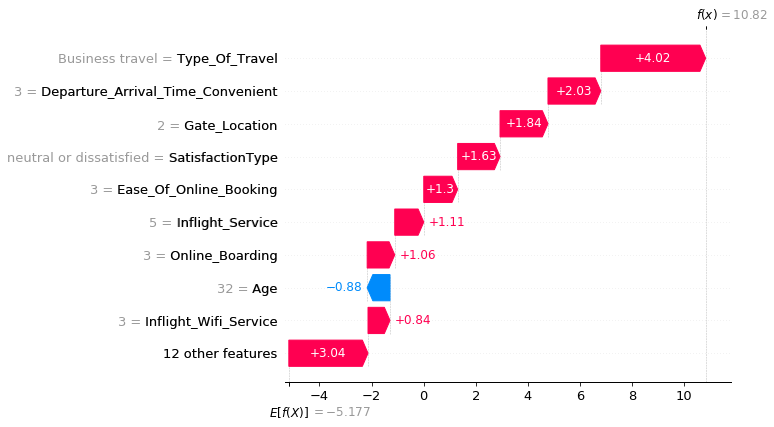

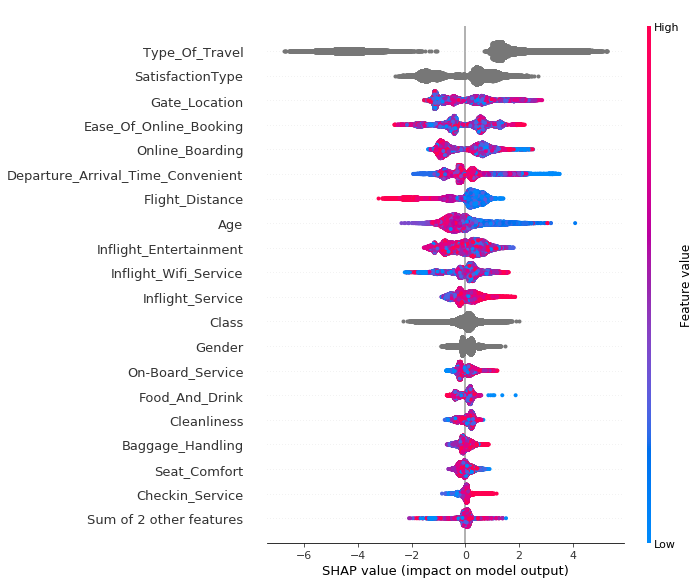

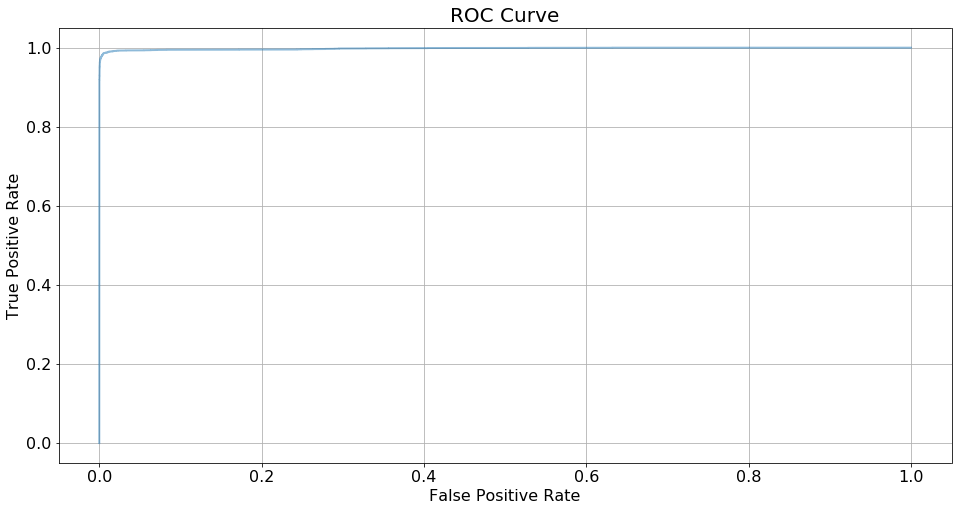

In [12]:
explainer = shap.Explainer(fit)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values, max_display=20)
#shap_values
fpr, tpr, thresholds = get_roc_curve(fit, test_pool, plot=True)


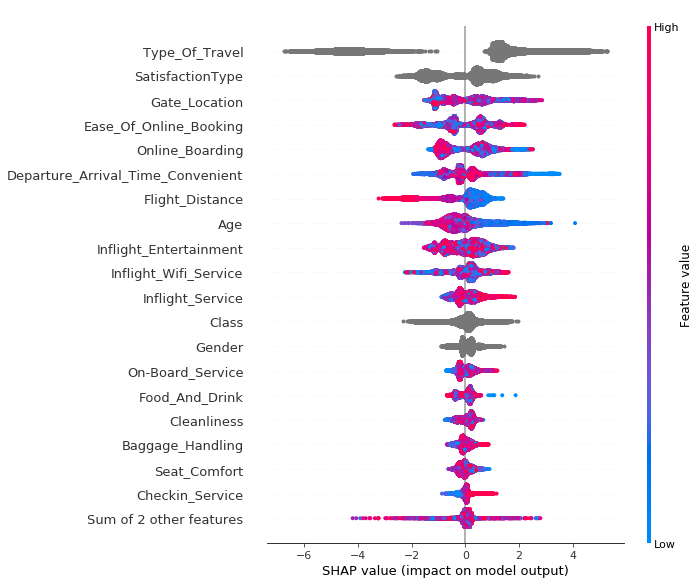

In [13]:
shap.plots.beeswarm(shap_values, max_display=20, show = False)
plt.savefig("model_output.png",dpi=150, bbox_inches='tight')

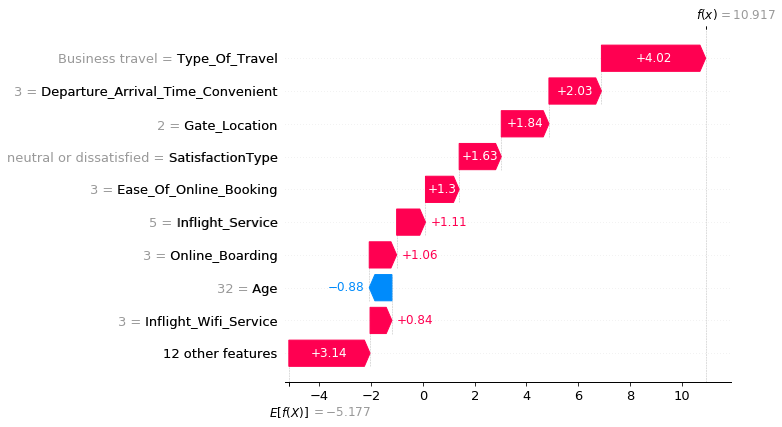

In [14]:
shap.plots.waterfall(shap_values[0], show = False)
plt.savefig("model_output_waterfall.png",dpi=150, bbox_inches='tight')

#### 7.3 Logistic, k-Nearest Neighbor, Random Forest, and Support Vector Machine Classifiers

##### 7.3.1 Feature preparation, and Train-Test split

In [15]:
cat_features = ['SatisfactionType', 'Gender', 'Class', 
             'Type_Of_Travel', 'Inflight_Wifi_Service', 
              'Ease_Of_Online_Booking', 
             'Gate_Location', 'Food_And_Drink', 'Online_Boarding', 'Seat_Comfort', 'Inflight_Entertainment',
             'On-Board_Service', 'Leg_Room_Service', 'Baggage_Handling', 'Checkin_Service', 'Inflight_Service',
             'Cleanliness']
numeric_features = ['Age', 'Flight_Distance','Departure_Delay_In_Minutes']
Seed_ = 201
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state= Seed_)
# This may seem repititative. But these models can be evaluated independent of the CatBoostClassifier.
# We used the same seed value.

##### 7.3.2 Transformers and Pipelines for the Classifiers.

In [16]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = cat_features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lr_classifier', LogisticRegression())])
clf_knn = Pipeline(steps=[('preprocessor', preprocessor),
                        ('knn_classifier',KNeighborsClassifier(n_neighbors=5))])
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('rf_classifier',RandomForestClassifier())])
clf_svm = Pipeline(steps=[('preprocessor', preprocessor),
                        ('svc_classifier',LinearSVC())])


# Testing Logistic Regression.M
# clf_lr.fit(X_train, y_train)
# print("model score: %.3f" % clf_lr.score(X_test, y_test))

##### 7.3.2 Logistic Regression, knn, random forest, and support vector machine classifiers.

In [17]:
param_grid_lr={"lr_classifier__C":np.logspace(-2,2,10),
               "lr_classifier__random_state":[16],
               "lr_classifier__penalty":["l2"]}
param_grid_knn={"knn_classifier__n_neighbors": np.linspace(1,5,2,dtype=int),
               "knn_classifier__weights":["uniform","distance"],
               "knn_classifier__metric":["euclidean","manhattan"]}
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
param_grid_rf={"rf_classifier__n_estimators": n_estimators, 
               "rf_classifier__random_state":[16],
               "rf_classifier__max_depth":[100],
               }
param_grid_svm = {"svc_classifier__C":np.linspace(0.2,1,3),"svc_classifier__dual": [False],
                  "svc_classifier__random_state":[16], "svc_classifier__max_iter": [2000]}

# LogisticClassifier
gs_est_lr = GridSearchCV(clf_lr, param_grid_lr, scoring="accuracy", cv=3, n_jobs=-1, verbose=1)
#gs_est_lr.fit(X_train, y_train)
#k-NearestNeighbor
gs_est_knn = GridSearchCV(clf_knn, param_grid_knn, scoring="accuracy", cv=3, n_jobs=-1, verbose=1)
#gs_est_knn.fit(X_train, y_train)
# RandomForest
gs_est_rf = GridSearchCV(clf_rf, param_grid_rf, scoring="accuracy", cv=3, n_jobs=-1, verbose=1)
#gs_est_rf.fit(X_train, y_train)
# SupportVectorMachine: LinearSVC
gs_est_svm = GridSearchCV(clf_svm, param_grid_svm, scoring="accuracy", cv=3, n_jobs=-1, verbose=1)
#gs_est_svm.fit(X_train, y_train)

estimators = [gs_est_lr, gs_est_knn, gs_est_rf, gs_est_svm]
fit_estimators = [est.fit(X_train, y_train) for est in estimators]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. 

Fitting 3 folds for each of 8 candidates, totalling 24 fits


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


tostring() is deprecated. Use tobytes() instead.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  2.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.9min finished
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

Fitting 3 folds for each of 3 candidates, totalling 9 fits


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. 

##### 7.3.2.1 Prediction and Scores: Logistic Regression

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, y

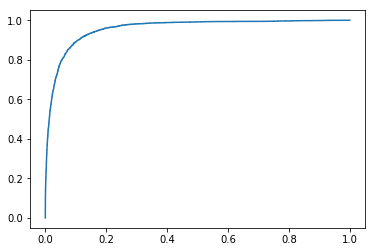

In [18]:
#lr
clf_lr = gs_est_lr.predict(X_test)
y_score = clf_lr
lr_auc = roc_auc_score(y_test, y_score)
lr_accuracy = accuracy_score(y_test, y_score)
y_prob = gs_est_lr.predict_proba(X_test)
fpr,tpr,thr = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr,tpr)

##### 7.3.2.2 Prediction and Scores: knn

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically 

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically 

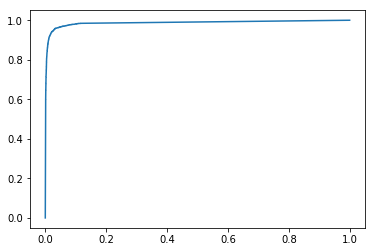

In [23]:
#knn
clf_knn = gs_est_knn.predict(X_test)
y_score = clf_knn
knn_auc = roc_auc_score(y_test, y_score)
knn_accuracy = accuracy_score(y_test, y_score)
y_prob = gs_est_knn.predict_proba(X_test)
fpr,tpr,thr = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr,tpr)


##### 7.3.2.3 Prediction and Scores: Random Forest

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, y

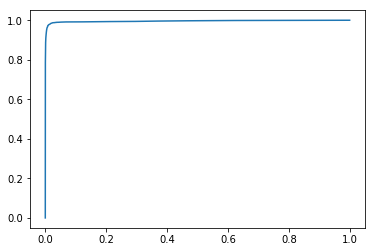

In [22]:
#RandomForest
clf_rf = gs_est_rf.predict(X_test)
y_score = clf_rf
rf_auc = roc_auc_score(y_test, y_score)
rf_accuracy = accuracy_score(y_test, y_score)
y_prob = gs_est_rf.predict_proba(X_test)
fpr,tpr,thr = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr,tpr)

##### 7.3.2.4 Prediction and Scores: Support Vector Machine

In [20]:
#svm
from sklearn.metrics import roc_auc_score
clf_svm = gs_est_svm.predict(X_test)
y_score = clf_svm
svm_auc = roc_auc_score(y_test, y_score)
svm_accuracy = accuracy_score(y_test, y_score)
# y_prob = gs_est_svm.predict_proba(X_test)
# fpr,tpr,thr = roc_curve(y_test, y_prob[:,1])
# plt.plot(fpr,tpr)


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, y

In [ ]:
# ##### 7.3.2.5 Prediction and Scores: Logistic Regression nusvm
# clf_nusvm_ = gs_est_svm.predict(X_test)
# y_score = clf_nusvm_
# nusvm_auc = roc_auc_score(y_test, y_score)
# nusvm_accuracy = accuracy_score(y_test, y_score)
# # y_prob = gs_est_svm.predict_proba(X_test)
# # fpr,tpr,thr = roc_curve(y_test, y_prob[:,1])
# # plt.plot(fpr,tpr)

#### 7.3.3 Classifier Accuracy Scores


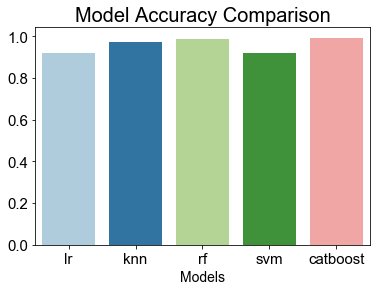

In [27]:
acc_score = [lr_accuracy, knn_accuracy, rf_accuracy, svm_accuracy, accuracy]
acc_labels = ['lr','knn','rf','svm','catboost']
sns.color_palette("Paired",)
ax = sns.barplot(x=acc_labels, y=acc_score, palette="Paired")
# ax.set(xlabel='models', ylabel='accuracy score')
sns.set_style('darkgrid')
ax.axes.set_title("Model Accuracy Comparison",fontsize=20)
ax.set_xlabel("Models",fontsize=14)
ax.tick_params(labelsize=15)
# sns.plt.show()
plt.show()
ax.figure.savefig('file.png')

## Part 8: Future Work

## Feature Correlation (in-progress)

In [ ]:
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
label = LabelEncoder()
cmap = "YlGnBu"
labeled_df = df.copy()


for labels in cat_features:
    labeled_df[labels] = label.fit_transform(labeled_df[labels])
#df_corr_list = [label.fit_transform(df[labels]) for labels in cat_features]
plt.figure(figsize=(15, 12))
sns.heatmap(labeled_df.corr(), cmap=cmap)
plt.title('Correlation using Heatmap', fontsize=14)
plt.show()

## Future Work: CatboostClassifier (in-progress)
##### HYPER PARAMETER Optimization

In [ ]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=250,
        eval_metric='Accuracy',
        random_seed=42,
        verbose=False,
        loss_function='Logloss')
    
    pool = Pool(X, y, cat_features=categorical_features_indices)
    params = model.get_params()
    cv_data = cv(pool=pool, params=params, fold_count=5)
    
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises
#______________________________________________________________________________________________
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-2, 5e-1)}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=25,
    trials=trials,
    rstate=RandomState(123))

print(f'The best parameters : {best}')
#______________________________________________________________________________________________
# Model Using Optimized Hyper-Parameters
Model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=250,
    eval_metric='Accuracy',
    random_seed=42,
    loss_function='Logloss',
    logging_level='Silent')
#______________________________________________________________________________________________
# Accuracy on Validation Data
pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
params = model.get_params()
cv_data = cv(pool=pool, params=params, fold_count=5, seed=42)

mean_accuracy = np.max(cv_data['test-Accuracy-mean'])
print(f'Mean Accuracy on the Validation Data: {round(mean_accuracy,4)}')
#_______________________________________________________________________________________________
#Model Validation
#Applying Model on the Test Dataset
fit = model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    logging_level='Silent',  
    plot=False)
#_____________________________________________________________________________

#Model Accuracy on Test Data
eval_test = fit.eval_metrics(test_pool, ['AUC'], plot=False)
theAUC = np.mean( np.array(eval_test['AUC']) )
print(f"The AUC : { round(theAUC,4) }")
confusion_matrix = get_confusion_matrix(fit, test_pool)
print(confusion_matrix)
accuracy = accuracy_score(y_test, model.predict(X_test))
print( round(accuracy,4) )
fpr,tpr,thresholds = get_roc_curve(fit, test_pool, plot=True)

#_____________________________________________________________________________
#Feature Importance, Shap values and feature importance
fit.get_feature_importance(prettified=True)
explainer = shap.Explainer(fit)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)
#_____________________________________________________________________________
#_____________________________________________________________________________
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

eval_test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
curve = get_roc_curve(model, eval_test_pool)

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)
#_____________________________________________________________________________
#                  False Positive/Negative Plot
#_____________________________________________________________________________

import matplotlib.pyplot as plt
plt.figure( figsize=(12,6) )
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()


In [ ]:
explainer = shap.Explainer(fit)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values, max_display=20)
#shap_values
fpr, tpr, thresholds = get_roc_curve(fit, test_pool, plot=True)


## Future Work: Other Classifier 

In [ ]:
# from sklearn.svm import NuSVC
# clf_nusvm = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('Nusvc_classifier',NuSVC())])
# param_grid_nusvm = {"Nusvc_classifier__nu":np.linspace(0.2,.8,2),"Nusvc_classifier__probability": [True],
#                   "Nusvc_classifier__random_state":[16]}

# gs_est_nusvm = GridSearchCV(clf_nusvm, param_grid_nusvm, scoring="accuracy", cv=5, n_jobs=-1, verbose=1)



In [ ]:
# gs_est_nusvm.fit(X_train,y_train)